## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv("ab_data.csv")
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [7]:
n_row=df.shape[0]
n_row

294478

c. The number of unique users in the dataset.

In [6]:
users=df.user_id.nunique()
users

290584

d. The proportion of users converted.

In [11]:
prop_cnv=df.query('converted==1').shape[0]/n_row
prop_cnv

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [13]:
 """
 Number of rows, when group is not treatment but landing page is the new page
 """
grp_npage=df.query('group!="treatment" and landing_page=="new_page"').shape[0]

"""
 Number of rows, when group is not control but landing page is the old page
 """
grp_opage= df.query('group!="control" and landing_page=="old_page"').shape[0]

# summing both the grps

grp_sum=grp_npage+grp_opage
grp_sum

3893

f. Do any of the rows have missing values?

In [15]:
sum([True for idx,row in df.iterrows() if any(row.isnull())])

0

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [18]:
# dataframe where treatment is not aligned with new_page or control is not aligned with old_page 
df2 = df[((df.group=='treatment') & (df.landing_page=='new_page')) | ((df.group=='control') & (df.landing_page=='old_page'))]

In [19]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [22]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [25]:
df2.user_id[df2.user_id.duplicated()]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [34]:
df2.loc[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [36]:
df2=df2.drop_duplicates()

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [39]:
prob_roP=df2.query('converted==1').shape[0]/df2.shape[0]
prob_roP

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [38]:
control_group = df2.query('group=="control" and converted==1').shape[0]/df2.query('group=="control"').shape[0]
control_group

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [40]:
treatment_group = df2.query('group=="treatment" and converted==1').shape[0]/df2.query('group=="treatment"').shape[0]
treatment_group

0.11880724790277405

d. What is the probability that an individual received the new page?

In [42]:
rec_np=df2.query('landing_page=="new_page"').shape[0]/df2.shape[0]
rec_np

0.5000636646764286

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

In [86]:
actual_diff=(df2.query('converted == 1 and group == "control"').shape[0] / df2.query('group == "control"').shape[0]) - \
df2.query('converted == 1 and group == "treatment"').shape[0] / df2.query('group == "treatment"').shape[0]
actual_diff

0.0015790565976871451

**Your answer goes here.**
> - Probability of individual converting given individual is in control group = **0.1203863045004612.**
> - Probability of individual converting given individual is in treatment group = **0.11880724790277405.**
> - Difference in the conversion rate between the control and treatment group = **0.0015790565976871451**

Focusing on the above 3 points and specially the difference in the conversion rate of the control and treatment group, such a small difference gives a strong evidence that there isn't any further conversion between new page and old page. Since the conversion Probability of both are nearly same, then it is neccessary to analyse other factors too.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

**Null-hypothesis:**
> The difference between the population conversion rate of users given the new page and the old page will be equal to zero (the same) or lower than zero (the old page has a higher population conversion rate).

**Alternative-hypothesis**
> The alternative hypothesis is that the difference between the population conversion rate of users given the new page and the old page will be greater than zero to zero (the new page has a higher population conversion rate).

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [48]:
p_new = df2.query('converted == 1').shape[0] / df2.shape[0]
p_new

0.11959667567149027

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [49]:
p_old = df2.query('converted == 1').shape[0] / df2.shape[0]
p_old

0.11959667567149027

c. What is $n_{new}$, the number of individuals in the treatment group?

In [51]:
n_new=df2.query('group=="treatment"').shape[0]
n_new

145311

d. What is $n_{old}$, the number of individuals in the control group?

In [52]:
n_old=df2.query('group=="control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [76]:
new_page_converted = np.random.choice(2, n_new, replace = True, p=[(1-p_new), p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [77]:
old_page_converted = np.random.choice(2, n_old, replace = True, p=[(1-p_old), p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [78]:
diff=new_page_converted.mean()-old_page_converted.mean()
diff

-0.0012968786092630441

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [79]:
p_diffs=[]
for i in range(10000):
    new_page_converted = np.random.choice(2, n_new, replace = True, p=[(1-p_new), p_new])
    old_page_converted = np.random.choice(2, n_old, replace = True, p=[(1-p_old), p_old])
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())    

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

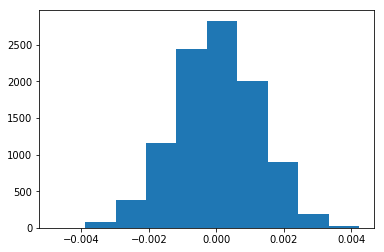

In [85]:
plt.hist(p_diffs);

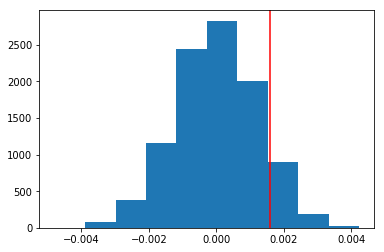

In [88]:
plt.hist(p_diffs)
plt.axvline(x=actual_diff, color='red');
plt.show()

With the null simulated distribution having normalized set of values, the mean of the distribution is zero while the actual rate difference is near the null distribution mean, thus there is a lack of statistical departure from the null hypothesis.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv** ?

In [91]:
(np.array(p_diffs) > actual_diff).mean()

0.1027

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**

> - Type I error rate is 5% & Pold > Alpha, thus we're unable to reject the null.Since the p-value is higher than the Type I error rate of 5%, we fail to reject the null hypothesis, and that the treatment page does not have higher conversion rates than the control page on a statistically significant basis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [95]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted == 1').shape[0]
convert_new = df2.query('group == "treatment" & converted == 1').shape[0]
n_old = df2.shape[0] - df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [96]:
#Computing z_score and p_value
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old, n_new],alternative='smaller') 

#display z_score and p_value
print(z_score,p_value)

1.2862985368 0.900830553521


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [104]:
from scipy.stats import norm
norm.cdf(z_score) #how significant our z_score is

0.90083055352094377

In [105]:
norm.ppf(1-(0.05)) #critical value of 95% confidence

1.6448536269514722

**Put your answer here.**
> - The z-score and p-value calculated above suggest that the conversion rates for the old page & new page aren't statistically different & theyrn't rejecting the null hypothesis.
> - The z-score indicates that the test statistic is near to the null mean, and the p-value indicates the statistical significance to affirm the previous findings previously but failed to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [97]:
#adding an intercept column
df2['intercept'] = 1

#Creating dummy variable column
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [102]:
import statsmodels.api as sm
model=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=model.fit() 

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [108]:
'''
As chisqprob is eleminated in the new update of scipy thus we need to do this workaround to view the summary of the result
'''

from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [109]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Fri, 19 Jun 2020   Pseudo R-squ.:               8.085e-06
Time:                        16:36:20   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Put your answer here.**
- The p-value associated with ab_page is **0.190** which differs from Part II. 
> -   The test for Part 2 were based on a hypothesis of one page with higher rate of conversion. 
> -    Whereas this test is based on the difference in the conversion rates of the pages, which is determined statistically.
- A null hypothesis for this circumstance would be the old page and new page with same conversion rate.
- The alternative hypothesis will be pages with different conversion rates.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**
> - Other factor can be the timestamp variable. We can check if the converted rate depends on certain time of the day or certain day when user browse the website.
> - **Disadavantage:** Adding additional terms into regression model will make interpretation more complex.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [113]:
cnt_data=pd.read_csv("countries.csv")
df_new = cnt_data.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new[['CA', 'IN', 'UK']] = pd.get_dummies(df_new['country'])
df_new['intercept'] = 1
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'IN', 'CA']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [114]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            3
Date:                Fri, 19 Jun 2020   Pseudo R-squ.:               2.324e-05
Time:                        16:54:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1758
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0150      0.011     -1.308      0.191      -0.037       0.007
IN             0.0099      0.013      0.744      0.457      -0.016       0.036
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
==============================================================================
"""

**Summary:**
> - The  country of origin and the type of page based on their p-values do not provide a statistical basis to reject the null hypothesis.
> - The difference in the conversion rates of the control and treatment group is so minute thus do not have significant impact for switch to the new page or to stay with the old one.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [115]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0